## IN3050/IN4050 Mandatory Assignment 2, 2022: Supervised Learning

### Rules

Before you begin the exercise, review the rules at this website: https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html , in particular the paragraph on cooperation. This is an individual assignment. You are not allowed to deliver together or copy/share source-code/answers with others. By submitting this assignment, you confirm that you are familiar with the rules and the consequences of breaking them.

### Delivery

**Deadline**: Friday, March 25, 2022, 23:59

Your submission should be delivered in Devilry. You may redeliver in Devilry before the deadline, but include all files in the last delivery, as only the last delivery will be read. You are recommended to upload preliminary versions hours (or days) before the final deadline.

### What to deliver?

You are recommended to solve the exercise in a Jupyter notebook, but you might solve it in a Python program if you prefer.

If you choose Jupyter, you should deliver the notebook. You should answer all questions and explain what you are doing in Markdown. Still, the code should be properly commented. The notebook should contain results of your runs. In addition, you should make a pdf of your solution which shows the results of the runs. (If you can't export: notebook -> latex -> pdf on your own machine, you may do this on the IFI linux machines.)

If you prefer not to use notebooks, you should deliver the code, your run results, and a pdf-report where you answer all the questions and explain your work.

Your report/notebook should contain your name and username.

Deliver one single zipped folder (.zip, .tgz or .tar.gz) which contains your complete solution.

Important: if you weren’t able to finish the assignment, use the PDF report/Markdown to elaborate on what you’ve tried and what problems you encountered. Students who have made an effort and attempted all parts of the assignment will get a second chance even if they fail initially. This exercise will be graded PASS/FAIL.

### Goals of the assignment
The goal of this assignment is to get a better understanding of supervised learning with gradient descent. It will, in particular, consider the similarities and differences between linear classifiers and multi-layer feed forward networks (multi-layer perceptron, MLP) and the differences and similarities between binary and multi-class classification. A main part will be dedicated to implementing and understanding the backpropagation algorithm. 

### Tools
The aim of the exercises is to give you a look inside the learning algorithms. You may freely use code from the weekly exercises and the published solutions. You should not use ML libraries like scikit-learn or tensorflow.

You may use tools like NumPy and Pandas, which are not specific ML-tools.

The given precode uses NumPy. You are recommended to use NumPy since it results in more compact code, but feel free to use pure python if you prefer. 

### Beware
There might occur typos or ambiguities. This is a revised assignment compared to earlier years, and there might be new typos. If anything is unclear, do not hesitate to ask. Also, if you think some assumptions are missing, make your own and explain them!

### Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn #for datasets

# Part 1: Linear classifiers
## Datasets
We start by making a synthetic dataset of 2000 datapoints and five classes, with 400 individuals in each class. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html regarding how the data are generated.) We choose to use a synthetic dataset---and not a set of natural occuring data---because we are mostly interested in properties of the various learning algorithms, in particular the differences between linear classifiers and multi-layer neural networks together with the difference between binary and multi-class data.

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by scikit, but that will not be the case with real-world data.) We should split the data so that we keep the alignment between X and t, which may be achieved by shuffling the indices. We split into 50% for training, 25% for validation, and 25% for final testing. The set for final testing *must not be used* till the end of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments. This is done by the `random_state` argument and the `rng = np.random.RandomState(2022)`.

In [681]:
from sklearn.datasets import make_blobs
X, t = make_blobs(n_samples=[400,400,400, 400, 400], centers=[[0,1],[4,1],[8,1],[2,0],[6,0]], 
                  n_features=2, random_state=2019, cluster_std=1.0)

In [760]:
indices = np.arange(X.shape[0])
rng = np.random.RandomState(2022)
rng.shuffle(indices)
indices[:10]

array([1018, 1295,  643, 1842, 1669,   86,  164, 1653, 1174,  747])

In [761]:
X_train = X[indices[:1000],:]
X_val = X[indices[1000:1500],:]
X_test = X[indices[1500:],:]
t_train = t[indices[:1000]]
t_val = t[indices[1000:1500]]
t_test = t[indices[1500:]]

Next, we will  make a second dataset by merging the two smaller classes in (X,t) and call the new set (X, t2). This will be a binary set.

In [762]:
t2_train = t_train >= 3
t2_train = t2_train.astype('int')
t2_val = (t_val >= 3).astype('int')
t2_test = (t_test >= 3).astype('int')

We can plot the two traing sets.

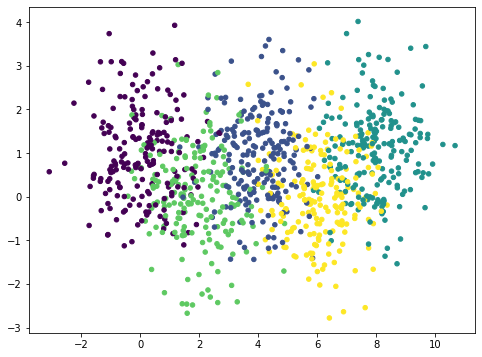

In [6]:
plt.figure(figsize=(8,6)) # You may adjust the size
plt.scatter(X_train[:, 0], X_train[:, 1], c=t_train, s=20.0)
plt.show()

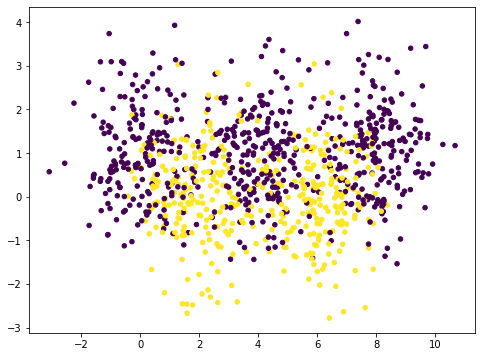

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=t2_train, s=20.0)
plt.show()

## Binary classifiers

### Linear regression
We see that that set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression. You may make your own implementation from scratch or start with the solution to the weekly exercise set 7, which we include here.

In [8]:
def add_bias(X):
    # Put bias in position 0
    sh = X.shape
    if len(sh) == 1:
        #X is a vector
        return np.concatenate([np.array([1]), X])
    else:
        # X is a matrix
        m = sh[0]
        bias = np.ones((m,1)) # Makes a m*1 matrix of 1-s<
        return np.concatenate([bias, X], axis  = 1) 

In [9]:
class NumpyClassifier():
    """Common methods to all numpy classifiers --- if any"""
    
    def accuracy(self,X_test, y_test, **kwargs):
        pred = self.predict(X_test, **kwargs)
        if len(pred.shape) > 1:
            pred = pred[:,0]
        return np.sum(pred==y_test)/len(pred)

In [10]:
class NumpyLinRegClass(NumpyClassifier):
    
    def add_bias(self, X):                        
        return np.concatenate([np.ones((X.shape[0],1)), X], axis=1)

    def fit(self, X_train, y_train, loss_diff, eta = 0.1, epochs=10, val=[]): 
        
        if len(val) > 0: 
            loss_over_epochs = []
            val_loss_over_epochs = []
            self.weights = np.zeros(X_train.shape[1]+1)
            
            X_val, y_val = val[0], val[1]
            self.val_weights = np.zeros(X_val.shape[1]+1)
            
            X_val = self.add_bias(X_val)
            X_train = self.add_bias(X_train)
            
            for e in range(epochs):   
                loss_over_epochs.append(self.loss(X_train, y_train, w=self.weights))
                val_loss_over_epochs.append(self.loss(X_val, y_val, w=self.val_weights))
                
                weights1 = self.weights.copy()
                self.val_weights -= eta * self.gradient(X_val, y_val, w=self.val_weights)
                update = eta * self.gradient(X_train, y_train)
                self.weights -= update
                
                if(abs(update.sum()) <= loss_diff): 
                    print(abs(update.sum()))
                    print(e)
                    epochs = e
                    break    
            else: 
                loss_over_epochs = []
                self.weights = np.zeros(X_train.shape[1]+1)
                X_train = self.add_bias(X_train)
                for e in range(epochs): 
                    loss_over_epochs.append(self.loss(X_train, y_train))
                    weights1 = self.weights.copy()
                    update = eta * self.gradient(X_train, y_train)
                    self.weights -= update

                    if(abs(update.sum()) < loss_diff): 
                        print(abs(update.sum()))
                        print(e)
                        break
    
    def gradient(self, X, Y, w=[]): 
        if len(w)==0: 
            return X.T @ (X @ self.weights -Y ) / X.shape[0]
        else: 
            return X.T @ (X @ w -Y ) / X.shape[0]
        
    def loss(self, X, Y, w=0): 
        if len(w)==0: 
            return np.sum((1/2)*(X@self.weights-Y)**2)
        else: 
            return np.sum((1/2)*(X@w-Y)**2)
    
    def accuracy(self,X_test, y_test, **kwargs):
        pred = self.predict(X_test, **kwargs)
        if len(pred.shape) > 1:
            pred = pred[:,0]
        return np.sum(pred==y_test)/len(pred)

    def predict(self, X, threshold=0.5): 
        X = self.add_bias(X)
        pred = X@self.weights
        return np.where(pred > threshold, 1, 0)

We can train and test a first classifier.

In [11]:
cl = NumpyLinRegClass()
cl.fit(X_train, t2_train)
cl.accuracy(X_val, t2_val)

0.49

In [12]:
def plot_decision_regions(X, t, clf=[], size=(8,6)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    #print(y_min, y_max)
    plt.figure(figsize=size) # You may adjust this

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.2, cmap = 'Paired')

    plt.scatter(X[:,0], X[:,1], c=t, s=20.0, cmap='Paired')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision regions")
    plt.xlabel("x0")
    plt.ylabel("x1")


#    plt.show()

#### Comment on linear regression classifier - from student

The following model uses the idea behind linear regression to first train the wieghts, and then use those to classify/predict a numeric label for each poitn in a new datapoint that is sent in to the predict method. The weights them selves are initated as a numpy.array, with the number of weights per node in a layer is equal to the number of features in the input_data + 1, since we add bias too. We then perform the training of those weights for å predefined number of iterations, more professionaly called 'epochs', or until the value of loss is less than a value specified in the 'loss_diff'-parameter.The training of the weights is based upon gradient decent, where the gradient is just the partial derivative of the loss function in this case. By the end of each epoch, when the gradient at the current point has been calculated, we multiply it by the learning rate, also called eta, and repeat the process. The same logic follows for every single machine learning algorithm/model presented here. 

9.885233658054965e-06
409


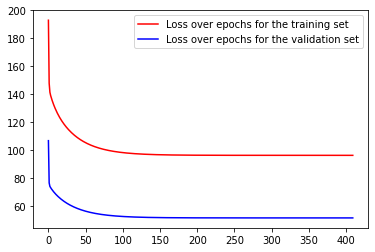

Accuracy for the training set:  70.7 %
Accuracy for the validation set:  66.8 %


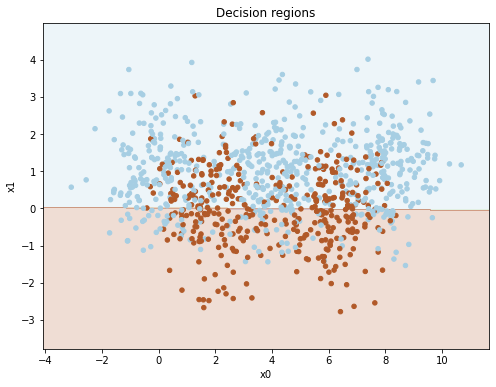

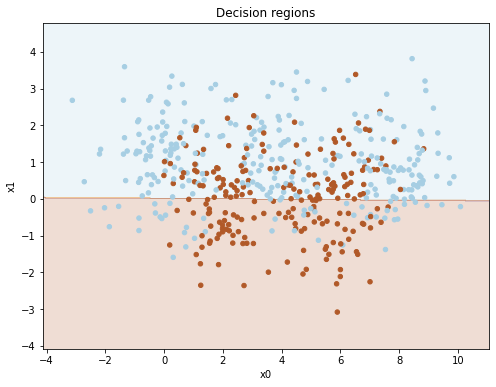

In [619]:
# My linear regression classifier
class LinearRegressionClassifier():

    def add_bias(self, X): 
                                
        return np.concatenate([np.ones((X.shape[0],1)), X], axis=1)

    # Remember that a validation set simply hepls us confirm that there's no point 
    # in further fitting of the weights past a given thresshold of epochs

    def fit(self, X_train, y_train, loss_diff, eta = 0.1, epochs=10, val=[]): 
        
        if len(val) > 0: 

            loss_over_epochs = []
            val_loss_over_epochs = []
            self.weights = np.zeros(X_train.shape[1]+1)
            
            X_val, y_val = val[0], val[1]
            self.val_weights = np.zeros(X_val.shape[1]+1)
            
            X_val = self.add_bias(X_val)
            X_train = self.add_bias(X_train)
            
            for e in range(epochs): 
                
                loss_over_epochs.append(self.loss(X_train, y_train, w=self.weights))
                val_loss_over_epochs.append(self.loss(X_val, y_val, w=self.val_weights))
                
                weights1 = self.weights.copy()
                self.val_weights -= eta * self.gradient(X_val, y_val, w=self.val_weights)
                update = eta * self.gradient(X_train, y_train)
                self.weights -= update
                

                if(abs(update.sum()) <= loss_diff): 
                    print(abs(update.sum()))
                    print(e)
                    epochs = e
                    break
            plt.plot([i for i in range(epochs+1)], loss_over_epochs, 'r', label='Loss over epochs for the training set ')
            plt.plot([i for i in range(epochs+1)], val_loss_over_epochs, 'b', label='Loss over epochs for the validation set')
            plt.legend()
            plt.show()
          

        else: 
            
            loss_over_epochs = []
            self.weights = np.zeros(X_train.shape[1]+1)
            X_train = self.add_bias(X_train)
            for e in range(epochs): 
                loss_over_epochs.append(self.loss(X_train, y_train))
                weights1 = self.weights.copy()
                update = eta * self.gradient(X_train, y_train)
                self.weights -= update
                
                if(abs(update.sum()) < loss_diff): 
                    print(abs(update.sum()))
                    print(e)
                    break
        
       

    def gradient(self, X, Y, w=[]): 
        if len(w)==0: 
            return X.T @ (X @ self.weights -Y ) / X.shape[0]
        else: 
            return X.T @ (X @ w -Y ) / X.shape[0]
        
    def loss(self, X, Y, w=[]): 
        if len(w)==0: 
            return np.sum((1/2)*(X@self.weights-Y)**2)
        else: 
            return np.sum((1/2)*(X@w-Y)**2)
    
    def accuracy(self,X_test, y_test, **kwargs):
        pred = self.predict(X_test, **kwargs)
        if len(pred.shape) > 1:
            pred = pred[:,0]
        return np.sum(pred==y_test)/len(pred)

    def predict(self, X, threshold=0.5): 
        X = self.add_bias(X)
        pred = X@self.weights
        return np.where(pred > threshold, 1, 0)

lrgd = LinearRegressionClassifier()
# good results with epoch = 300 ,eta = 0.05 and loss_diff = 0.00001
lrgd.fit(X_train, t2_train, 0.00001, eta=0.05, epochs = 1000, val=[X_val, t2_val])
print("Accuracy for the training set: ", lrgd.accuracy(X_train, t2_train)*100, "%")
print("Accuracy for the validation set: ", lrgd.accuracy(X_val, t2_val)*100, "%")
plot_decision_regions(X_train, t2_train, lrgd)
plot_decision_regions(X_val, t2_val, lrgd)


The result is far from impressive. Experiment with various settings for the hyper-parameters, eta and epochs. Report how the accuracy vary with the hyper-parameter settings. When you are satisfied with the result, you may plot the decision boundaries, as below.

Feel free to improve the colors and the rest av of the graphics. We have chosen a simple set-up which can be applied to more than two classes without substanial modifications.

### Loss
The linear regression classifier is trained with mean squared error loss. So far, we have not calculated the loss explicitly in the code. Extend the code to calculate the loss on the training set for each epoch and to store the losses such that the losses can be inspected after training. 

Train a classifier with your best settings from last point. After training, plot the loss as a function of the number of epochs.

### Control training
The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the fit-method with a keyword argument, `loss_diff`, and stop training when the loss has not improved with more than loss_diff. Also add an attribute to the classifier which tells us after fitting how many epochs were ran.

In addition, extend the fit-method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to fit, calculate the loss for the validation set, and the accuracy for both the training set and the validation set for each epoch.

Train classifiers with the best value for learning rate so far, and with varying values for `loss_diff`. For each run report, `loss_diff`, accuracy and number of epochs ran.

After a succesful training, plot both training loss snd vslidation loss as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. Comment on what you see.

### Logistic regression
You should now do similarly for a logistic regression classifier. Calculate loss and accuracy for training set and, when provided, also for validation set.

Remember that logistic regression is trained with cross-entropy loss. Hence the loss function is calculated differently than for linear regression.

After a succesful training, plot both losses as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. 

Comment on what you see. Do you see any differences between the linear regression classifier and the logistic regression classifier on this dataset?

#### Starting point: Code from weekly 7

### Comment from student

After running logisitc regression several times, I only notices a slight increase in accuracy, about 1%, else than that I don't see any difference in performance worth mentioning. 

In [14]:
def logistic(x):
    return 1/(1+np.exp(-x))

In [608]:
class NumpyLogReg(NumpyClassifier):

    def add_bias(self, X): 
        if len(X.shape) == 1:
        #X is a vector
            return np.concatenate([np.array([1]), X])
        else: 
            return np.concatenate([np.ones((X.shape[0],1)), X], axis=1)


    def forward(self, X): 
        s = X@self.weights
        return self.activation(s)
        
        
    def activation(self, z): 
        return 1. / (1. + np.exp(-z))
        
    def gradient(self, X, Y): 
        return X.T @ (self.forward(X) -Y) / X.shape[0]

    def fit(self, X_train, y_train, loss_diff, eta=0.001, epochs=1, val=[]): 
        
        if len(val) > 0: 

            loss_over_epochs = []
            val_loss_over_epochs = []
            accuracies_tra = []
            accuracies_val = []
            self.weights = np.zeros(X_train.shape[1]+1)
            
            X_val, y_val = val[0], val[1]
            self.val_weights = np.zeros(X_val.shape[1]+1)
            
            X_val = self.add_bias(X_val)
            X_train = self.add_bias(X_train)
            
            for e in range(epochs): 
                
                loss_over_epochs.append(self.loss(X_train, y_train))
                val_loss_over_epochs.append(self.loss(X_val, y_val))
                accuracies_tra.append(self.accuracy(X_train[:,1:], y_train))
                accuracies_val.append(self.accuracy(X_val[:,1:], y_val))
                
                
                weights1 = self.weights.copy()
                self.val_weights -= eta * self.gradient(X_val, y_val)
                update = eta * self.gradient(X_train, y_train)
                self.weights -= update
                

                if(abs(update.sum()) <= loss_diff): 
                    print(abs(update.sum()))
                    print(e)
                    epochs = e
                    break

            plt.plot([i for i in range(epochs)], loss_over_epochs, 'r', label='Loss: Training set ')
            plt.plot([i for i in range(epochs)], val_loss_over_epochs, 'b', label='Loss: Validation set')
            plt.legend()
            plt.show()
            plt.plot([i for i in range(epochs)], accuracies_tra, 'g', label='Accuracy: Training set')
            plt.plot([i for i in range(epochs)], accuracies_val, 'y', label='Accuracy: Validation set')
            plt.legend()
            plt.show()

        else: 
            
            loss_over_epochs = []
            self.weights = np.zeros(X_train.shape[1]+1)
            X_train = self.add_bias(X_train)
            for e in range(epochs): 
                loss_over_epochs.append(self.loss(X_train, y_train))
                weights1 = self.weights.copy()
                update = eta * self.gradient(X_train, y_train)
                self.weights -= update
                
                if(abs(update.sum()) < loss_diff): 
                    print('Training stopped after ', e, ' epochs')
                    print("The minimal threshold value for error is reached: ", abs(update.sum()))
                    break
                    
    def loss(self, X, Y, threeshold=0.5):
        pred = self.forward(X)
        # Using average to get a visually more pleseant output on the 
        # plot of th loss function
        return -np.average((Y*np.log(pred)) + ((1-Y)*np.log(1-pred)))
    
    def predict(self, x, treshold=0.5): 
        x = self.add_bias(x)
        pred = self.forward(x)
        return np.where(pred >= treshold, 1, 0)
    
    def score(self, x):
        z = self.add_bias(x)
        score = self.forward(z)
        return score
    
    def accuracy(self,X_test, y_test, **kwargs):
        pred = self.predict(X_test, **kwargs)
        if len(pred.shape) > 1:
            pred = pred[:,0]
        return np.sum(pred==y_test)/len(pred)

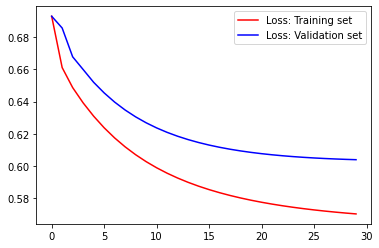

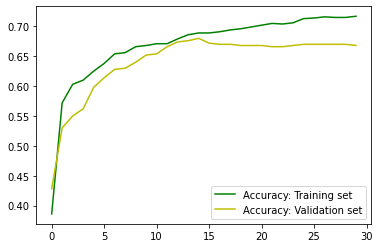

Accuracy for the training set:  71.8 %
Accuracy for the validation set:  66.8 %


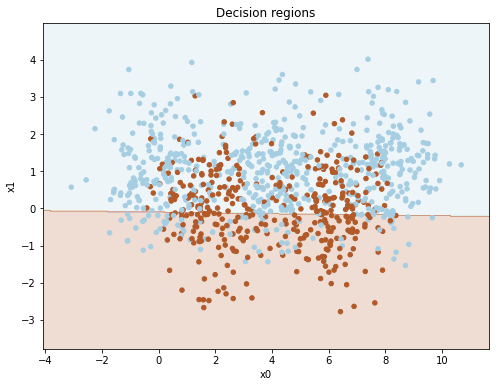

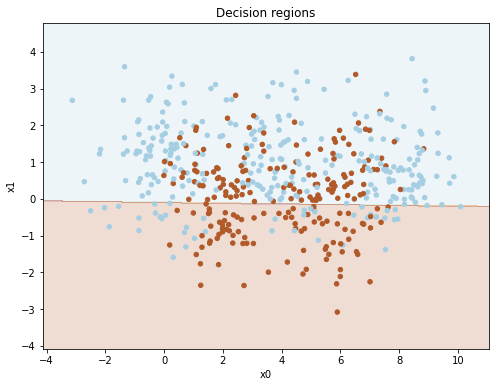

In [690]:
# My calssifier using logistic regression function as the activation function

class LogisiticRegressionClassifier(): 
        
    def add_bias(self, X): 
        if len(X.shape) == 1:
        #X is a vector
            return np.concatenate([np.array([1]), X])
        else: 
            return np.concatenate([np.ones((X.shape[0],1)), X], axis=1)


    def forward(self, X): 
        s = X@self.weights
        return self.activation(s)
        
        
    def activation(self, z): 
        return 1. / (1. + np.exp(-z))
        
    def gradient(self, X, Y): 
        return X.T @ (self.forward(X) -Y) / X.shape[0]

    def fit(self, X_train, y_train, loss_diff, eta=0.001, epochs=1, val=[]): 
        
        if len(val) > 0: 

            loss_over_epochs = []
            val_loss_over_epochs = []
            accuracies_tra = []
            accuracies_val = []
            self.weights = np.zeros(X_train.shape[1]+1)
            
            X_val, y_val = val[0], val[1]
            self.val_weights = np.zeros(X_val.shape[1]+1)
            
            X_val = self.add_bias(X_val)
            X_train = self.add_bias(X_train)
            
            for e in range(epochs): 
                
                loss_over_epochs.append(self.loss(X_train, y_train))
                val_loss_over_epochs.append(self.loss(X_val, y_val))
                accuracies_tra.append(self.accuracy(X_train[:,1:], y_train))
                accuracies_val.append(self.accuracy(X_val[:,1:], y_val))
                
                
                weights1 = self.weights.copy()
                self.val_weights -= eta * self.gradient(X_val, y_val)
                update = eta * self.gradient(X_train, y_train)
                self.weights -= update
                

                if(abs(update.sum()) <= loss_diff): 
                    print(abs(update.sum()))
                    print(e)
                    epochs = e
                    break

            plt.plot([i for i in range(epochs)], loss_over_epochs, 'r', label='Loss: Training set ')
            plt.plot([i for i in range(epochs)], val_loss_over_epochs, 'b', label='Loss: Validation set')
            plt.legend()
            plt.show()
            plt.plot([i for i in range(epochs)], accuracies_tra, 'g', label='Accuracy: Training set')
            plt.plot([i for i in range(epochs)], accuracies_val, 'y', label='Accuracy: Validation set')
            plt.legend()
            plt.show()

        else: 
            
            loss_over_epochs = []
            self.weights = np.zeros(X_train.shape[1]+1)
            X_train = self.add_bias(X_train)
            for e in range(epochs): 
                loss_over_epochs.append(self.loss(X_train, y_train))
                weights1 = self.weights.copy()
                update = eta * self.gradient(X_train, y_train)
                self.weights -= update
                
                if(abs(update.sum()) < loss_diff): 
                    print('Training stopped after ', e, ' epochs')
                    print("The minimal threshold value for error is reached: ", abs(update.sum()))
                    break
                    
    def loss(self, X, Y):
        pred = self.forward(X)
        # Using average to get a visually more pleseant output on the 
        # plot of th loss function
        return -np.average((Y*np.log(pred)) + ((1-Y)*np.log(1-pred)))
    
    def predict(self, x, treshold=0.5): 
        x = self.add_bias(x)
        pred = self.forward(x)
        return np.where(pred >= treshold, 1, 0)
    
    def score(self, x):
        z = self.add_bias(x)
        score = self.forward(z)
        return score
    
    def accuracy(self,X_test, y_test, **kwargs):
        pred = self.predict(X_test, **kwargs)
        if len(pred.shape) > 1:
            pred = pred[:,0]
        return np.sum(pred==y_test)/len(pred)


lrgd = LogisiticRegressionClassifier()
# Good settigns =>  0.00001, epochs = 120, eta=0.05
# Good settings => loss_diff = 0.00001, epochs = 60, eta=0.1
# Good settings => loss_diff = 0.00001, epochs = 30, eta=0.2
# Good settings => loss_diff = 0.00001, epochs = 625, eta=0.01
# Good settings => loss_diff = 0.00001, epochs = 10000, eta=0.001
lrgd.fit(X_train, t2_train, loss_diff=0.00001, epochs = 30, eta=0.2, val=[X_val, t2_val])
print("Accuracy for the training set: ", lrgd.accuracy(X_train, t2_train)*100, "%")
print("Accuracy for the validation set: ", lrgd.accuracy(X_val, t2_val)*100, "%")
plot_decision_regions(X_train, t2_train, lrgd)
plot_decision_regions(X_val, t2_val, lrgd)

from sklearn.preprocessing import StandardScaler


## Multi-class classifiers
We turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set (X, t).

### "One-vs-rest" with logistic regression
We saw in the lecture how a logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one logistic regression classifier for each class. To predict the class of an item, we run all the binary classifiers and collect the probability score from each of them. We assign the class which ascribes the highest probability.

Build such a classifier. Train the resulting classifier on (X_train, t_train), test it on (X_val, t_val), tune the hyper-parameters and report the accuracy.

Also plot the decision boundaries for your best classifier similarly to the plots for the binary case.

#### Comment on One-vs-rest - from student 

This calssifier follows the idea behind One-vs-rest as specified in the text for this subtask. This means training one classifier for each of the five classes. Before running this code, keep in mind that LogisiticRegressionClassifier above has to be run. 

The loss function is not plotted for this model.

Training stopped after  814  epochs
The minimal threshold value for error is reached:  9.999350994488745e-05
Training stopped after  447  epochs
The minimal threshold value for error is reached:  9.946774105539957e-05
Training stopped after  109  epochs
The minimal threshold value for error is reached:  9.283371415662301e-05
Training stopped after  1167  epochs
The minimal threshold value for error is reached:  9.970617291914283e-05
Accuracy achieved by OvR Logisitic regression model:  0.754


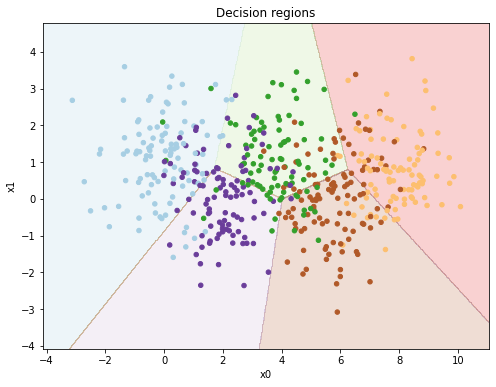

In [777]:

from copy import deepcopy 
from matplotlib.colors import ListedColormap 

class MultiLRGD():
    
    def fit(self, X_train, t_train, loss_diff=0.001, eta=0.1, epochs=10): 
        self.list_of_classifiers = []
        num_of_classes = np.max(t_train)+1
    
        for i in range(num_of_classes): 

            y_train = deepcopy(t_train)
            id_i = y_train == i
            id_n = y_train != i
            y_train[id_i] = 1
            y_train[id_n] = 0
            lrgd_cls = LogisiticRegressionClassifier()
            lrgd_cls.fit(X_train, y_train, loss_diff, eta, epochs)

            self.list_of_classifiers.append(lrgd_cls)

            
    def predict(self, x): 
        pred_prob = []
        predicted = []
        for i in range(len(x)):
            pred_prob.append(self.list_of_classifiers[0].score(x[i]))
            pred_prob.append(self.list_of_classifiers[1].score(x[i]))
            pred_prob.append(self.list_of_classifiers[2].score(x[i]))
            pred_prob.append(self.list_of_classifiers[3].score(x[i]))
            pred_prob.append(self.list_of_classifiers[4].score(x[i]))
            
            predicted.append(np.argmax(pred_prob))
            pred_prob.clear()
        return np.array(predicted)
    
    def accuracy(self,X_test, y_test, **kwargs):
        pred = self.predict(X_test, **kwargs)

        return np.sum(pred==y_test)/len(pred)




    
mLRGD = MultiLRGD()
mLRGD.fit(X_train, t_train, loss_diff = 0.0001, epochs = 10000, eta=0.2)
print('Accuracy achieved by OvR Logisitic regression model: ', mLRGD.accuracy(X_val, t_val))

    

plot_decision_regions(X_val, t_val, clf=mLRGD)
#plot_decision_regions(X_train, t_train, clf=mLRGD.list_of_classifiers[1])
#plot_decision_regions(X_train, t_train, clf=mLRGD.list_of_classifiers[2])
#plot_decision_regions(X_train, t_train, clf=mLRGD.list_of_classifiers[3])
#plot_decision_regions(X_train, t_train, clf=mLRGD.list_of_classifiers[4])


    
    


### For in4050-students: Multi-nominal logistic regression
The following part is only mandatory for in4050-students. In3050-students are also welcome to make it a try. Everybody has to return for the part 2 on multi-layer neural networks. 

In the lecture, we contrasted the one-vs-rest approach with the multinomial logistic regression, also called softmax classifier. Implement also this classifier, tune the parameters, and compare the results to the one-vs-rest classifier. (Don't expect a large difference on a simple task like this.)

Remember that this classifier uses exponetiation followed by softmax in the forward phase. For loss, it uses cross-entropy loss. The loss has a somewhat simpler form than in the binary case. To calculate the gradient is a little more complicated. The actual gradient and update rule is simple, however, as long as you have calculated the forward values correctly.

#### Testing of some code pieces used below in the multi-nomial logisitc regression model 

In [18]:


y_train = (np.arange(np.max(t_train)+1)==t_train[:, None]).astype(float)

rgen = np.random.RandomState(1)
weights = rgen.normal(loc=0.0, scale=0.01, size=1 + X_train.shape[1])

weights = np.zeros((X_train.shape[1]+1, y_train.shape[1]))
print(weights.shape )

def add_bias( X): 
        return np.concatenate([np.ones((X.shape[0],1)), X], axis=1)

def net_input(X, w): 
    X = add_bias(X)

    return (X@w)

def softmax(z): 
    return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

def softmax2(logits):
    exponentials = np.exp(logits)
    return exponentials / np.sum(exponentials, axis=1).reshape(-1, 1)

z = net_input(X_train, weights)

smax = softmax(z)
print(smax)
smax2 = softmax2(z)
print(smax2)

(3, 5)
[[0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 ...
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]]
[[0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 ...
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]]


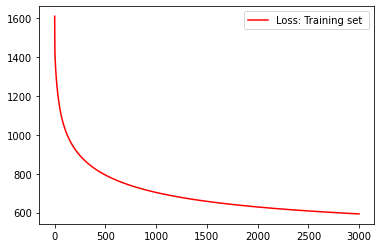

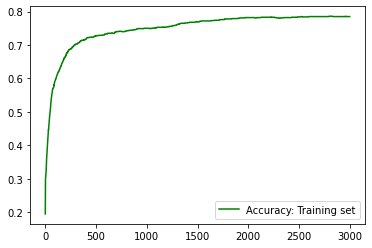

Accuracy achieved by multi-nomial logistic regression model:  0.76


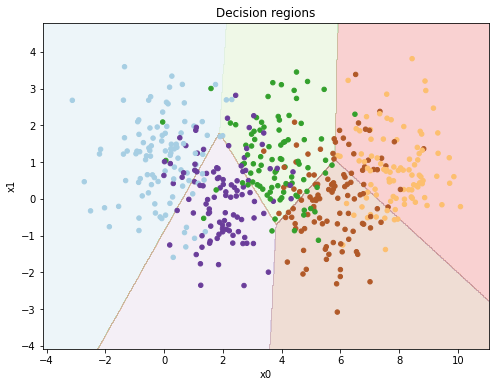

In [601]:
class SoftLRGD(): 
    
    def add_bias(self, X): 
        return np.concatenate([np.ones((X.shape[0],1)), X], axis=1)

    def forward(self, X): 
        s = X@self.weights
        return self.softmax(s)
        
    def softmax(self, z):
        return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1, 1)
        
    def gradient(self, X, Y): 
        return X.T @ (self.forward(X) - Y)/X.shape[0]

    def fit(self, X_train, y_train, loss_diff, eta=0.001, epochs=1, val=[]): 
            
        loss_over_epochs = []
        accuracies_train = []
        self.weights = np.zeros((X_train.shape[1]+1, y_train.shape[1]))
        X_train = self.add_bias(X_train)
        for e in range(epochs): 
            loss_over_epochs.append(self.loss(X_train, y_train))
            accuracies_train.append(self.accuracy(X_train[:,1:], self.decode(y_train)))
            weights1 = self.weights.copy()
            update = eta * self.gradient(X_train, y_train)
            self.weights -= update
        return epochs, loss_over_epochs, accuracies_train
        
    
    def loss(self, X, Y):
        pred = self.forward(X)
        return -np.sum((Y*np.log(pred)))
    
    def predict(self, x, treshold=0.5): 
        x = self.add_bias(x)
        pred = self.forward(x)
        l = np.argmax(pred, axis=1)
        return l.reshape(-1) 
        
    def score(self, x):
        z = add_bias(x)
        score = self.forward(z)
        return score
    
    def decode(self, Y): 
        l = np.argmax(Y, axis=1)
        return l.reshape(-1) 
    
    def accuracy(self,X_test, y_test, **kwargs):
        pred = self.predict(X_test, **kwargs)
        if len(pred.shape) > 1:
            pred = pred[:,0]
        return np.sum(pred==y_test)/len(pred)

def one_hot_encode(Y):
    n_labels = Y.shape[0]
    n_classes = 5
    encoded_Y = np.zeros((n_labels, n_classes))
    for i in range(n_labels):
        label = Y[i]
        encoded_Y[i][label] = 1
    return encoded_Y

sLRGD = SoftLRGD()
y_train = one_hot_encode(t_train)
y_val = one_hot_encode(t_val)

epochs, loss, accuracy = sLRGD.fit(X_train, y_train, loss_diff = 0.0001, epochs = 3000, eta=0.1, val=[])
plt.plot([i for i in range(epochs)], loss, 'r', label='Loss: Training set ')
plt.legend()
plt.show()
plt.plot([i for i in range(epochs)], accuracy, 'g', label='Accuracy: Training set')
plt.legend()
plt.show()
print("Accuracy achieved by multi-nomial logistic regression model: ", sLRGD.accuracy(X_val, t_val))
plot_decision_regions(X_val,t_val, sLRGD)

#### Comment on the classifier above - from student 

I had some minor issues with plotting the loss and accuracy for OvR regression, henec I decided to only plot the result for the mulinomial regression. As mentioned by the lecturer above, the difference in accuracy is close to none. One important notice though, is the fact that mulitnomial regression is faster than OvR.


# Part II
## Multi-layer neural networks
We will implement the Multi-layer feed forward network (MLP, Marsland sec. 4.2.1), where we use mean squared loss together with logistic activation in both the hidden and the last layer.

Since this part is more complex, we will do it in two rounds. In the first round, we will go stepwise through the algorithm with the dataset (X, t). We will initialize the network and run a first round of training, i.e. one pass through the algorithm at p. 78 in Marsland.

In the second round, we will turn this code into a more general classifier. We can train and test this on (X, t) and (X, t2), but also on other datasets.

## Round 1: One epoch of training

### Scaling
First we have to scale our data. Make a standard scaler (normalizer) and scale the data. Remember, not to follow Marsland on this point. The scaler should be constructed from the training data only, but be applied both to training data and later on to validation and test data.

#### Comment on scaling methods below 

Testing of scaling methods, and comparision with the scaling-functions available in sklearn-library

In [420]:


# The so-called min-max normalization 
def standardScaler(dataset): 
    
    scaled_data_set = (dataset - np.min(X_train))/(np.max(X_train)-np.min(X_train))
    
    return scaled_data_set

# We can also use the this version of the standard Scaler
def standardScaler2(data_set): 
    
    scaled_data_set = (data_set - np.average(X_train, axis=0))/(np.std(X_train, axis=0))
    
    return scaled_data_set

def standardScaler3(dataset): 
    min_on_training = X_train.min(axis=0)
    range_of_training = (X_train - min_on_training).max(axis=0)
    
    data_scaled = (dataset- min_on_training) /(range_of_training)
    return data_scaled

X_scaled = standardScaler3(X_train)
#t_scaled = standardScaler3(t_train)
print("MinMax1: ", X_scaled)
print("MinMax3: ", standardScaler(X_train))


X_scaled4 = standardScaler2(X_train)
print("STAND: ", X_scaled4)

from sklearn.preprocessing import MinMaxScaler, StandardScaler

m = MinMaxScaler() 
m.fit(X_train)
X_scaled2 = m.transform(X_train)
print("MinMax2: " ,X_scaled2)

s = StandardScaler()
s.fit(X_train)
X_scaled3 = s.transform(X_train)
print("STAND2: ", X_scaled3)



MinMax1:  [[0.50363242 0.43521425]
 [0.78618838 0.57975632]
 [0.31410927 0.27235863]
 ...
 [0.30046871 0.66601838]
 [0.42928029 0.54383327]
 [0.50418405 0.19744384]]
MinMax3:  [[0.50363242 0.23699307]
 [0.78618838 0.30835372]
 [0.31410927 0.15659098]
 ...
 [0.30046871 0.35094144]
 [0.42928029 0.29061845]
 [0.50418405 0.11960543]]
STAND:  [[-0.0764312  -0.37934793]
 [ 1.22755137  0.49386646]
 [-0.95107171 -1.36319899]
 ...
 [-1.01402227  1.01499688]
 [-0.41956284  0.27684639]
 [-0.07388545 -1.81577776]]
MinMax2:  [[0.50363242 0.43521425]
 [0.78618838 0.57975632]
 [0.31410927 0.27235863]
 ...
 [0.30046871 0.66601838]
 [0.42928029 0.54383327]
 [0.50418405 0.19744384]]
STAND2:  [[-0.0764312  -0.37934793]
 [ 1.22755137  0.49386646]
 [-0.95107171 -1.36319899]
 ...
 [-1.01402227  1.01499688]
 [-0.41956284  0.27684639]
 [-0.07388545 -1.81577776]]


### Initialization
We will only use one hidden layer. The number of nodes in the hidden layer will be a hyper-parameter provided by the user; let's call it *dim_hidden*. (*dim_hidden* is called *M* by Marsland.) Initially, we will set it to 3. This is a hyper-parameter where other values may give better results, and the hyper-parameter could be tuned.

Another hyper-parameter set by the user, is the learning rate. We set the initial value to 0.01, but also this may need tuning.

In [421]:
eta = 0.01 #Learning rate
dim_hidden = 3

We assume that the input *X_train* (after scaling) is a matrix of dimension *P x dim_in*, where *P* is the number of training instances, and *dim_in* is the number of features in the training instances (*L* in Marsland). Hence we can read *dim_in* off from *X_train*. 

The target values have to be converted from simple numbers, *0, 2,..* to "one-hot-encoded" vectors similarly to the multi-class task. After the conversion, we can read *dim_out* off from *t_train*. 

In [422]:


# convert t_train

def one_hot_encode(Y):
    n_labels = Y.shape[0]
    n_classes = 5
    encoded_Y = np.zeros((n_labels, n_classes))
    for i in range(n_labels):
        label = Y[i]
        encoded_Y[i][label] = 1
    return encoded_Y

def one_hot_encode(Y): 
    return (np.arange(np.max(Y) +1) == Y[:, None]).astype(int)

t_train_enc = one_hot_encode(t_train)

dim_in =  X_train.shape[1]  # Calculate the correct value from the input data
dim_out = t_train_enc.shape[1]  # Calculate the correct value from the input data
print(t_train_enc)

[[0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 ...
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]]


We need two sets of weights: weights1 between the input and the hidden layer, and weights2, between the hidden layer and the output. Make sure that you take the bias terms into consideration and get the correct dimensions. The weight matrices should be initialized to small random numbers, not to zeros. It is important that they are initialized randomly, both to ensure that different neurons start with different initial values and to generate different results when you rerun the classifier. In this introductory part, we have chosen to fix the random state to make it easier for you to control your calculations. But this should not be part of your final classifier.

In [423]:
# Your code
def init_weights(first_dim, second_dim): 
    rgen = np.random.RandomState(np.random.randint(5000))
    weights = rgen.normal(loc=0.0, scale=0.4, size=(first_dim+1, second_dim))
    return np.array(weights)

In [424]:
rng = np.random.RandomState(2022)
weights1 = (rng.rand(dim_in + 1, dim_hidden) * 2 - 1)/np.sqrt(dim_in)
print(weights1)
weights2 = (rng.rand(dim_hidden+1, dim_out) * 2 - 1)/np.sqrt(dim_hidden)
print(weights2)

[[-0.6938717  -0.00133246 -0.54675803]
 [-0.63643285  0.26220593 -0.01840165]
 [ 0.56237224  0.20852872  0.56139063]]
[[ 0.25534462  0.38261397  0.37824303  0.38518453  0.52774934]
 [-0.15236916 -0.00596099 -0.1853185   0.13790511  0.55140373]
 [-0.46599894  0.28198504 -0.23960097 -0.23246968  0.29153125]
 [-0.55579925  0.02740963  0.42081427 -0.12835323 -0.33233223]]


In [425]:
#init_weights(dim_in, dim_hidden)
init_weights(dim_hidden+1, t_train_enc.shape[1])

array([[ 0.18740884, -0.19984944, -0.44283393, -0.15265794,  0.25752908],
       [ 0.51888193, -0.31580953, -0.46192908,  0.52094593, -0.34631546],
       [-0.49037416,  0.06111239, -0.46633506, -0.51438149, -0.45653209],
       [ 0.15189644,  0.04690797, -0.64305588,  0.47426299, -0.35317768],
       [-0.53665798,  0.28724612, -0.44923069,  0.0944302 ,  0.73587492]])

### Forwards phase
We will run the first step in the training, and start with the forward phase. Calculate the activations after the hidden layer and after the output layer. We will follow Marsland and use the logistic (sigmoid) activation function in both layers. Inspect whether the results seem reasonable with respect to format and values.

In [426]:
bias = np.ones((X.shape[0],1))
bias[0] = -1
print(bias)

[[-1.]
 [ 1.]
 [ 1.]
 ...
 [ 1.]
 [ 1.]
 [ 1.]]


In [427]:
# Your code
# hidden_activations are 

def add_bias(X):    
    bias = np.ones((X.shape[0],1))
    bias[0] = -1
    return np.concatenate([bias, X], axis=1)

# Our activation is again the sigmpid function 
def activation(z):
    return 1. / (1. + np.exp(-z))

def hidden_activation(X, w1): 
    #w1 = init_weights(X.shape[1], dim_hidden)
    X = add_bias(X)
    hid_a = activation(X@w1)
    return hid_a
    
    

In [428]:
# Your code
# output_activations =

def output_activation(hid_a, w2): 
    #w2 = init_weights(hid_a.shape[1], dim_out)
    hid_b = add_bias(hid_a)
    output = activation(hid_b@w2)
    return output, w2


In [429]:
w1 = init_weights(X.shape[1], dim_hidden)
print(w1.shape)
h1 = hidden_activation(X_train, w1)
print(h1.shape)
w2 = init_weights(h1.shape[1], dim_out)
print(w2.shape)
output, w2 = output_activation(h1, w2)
print(output.shape)

#output = np.argmax(output, axis=1)
#output.reshape(-1, 1)
output

(3, 3)
(1000, 3)
(4, 5)
(1000, 5)


array([[0.45186404, 0.33603353, 0.65177079, 0.37858668, 0.30357181],
       [0.60161558, 0.65489117, 0.54241033, 0.37491178, 0.56206407],
       [0.62734348, 0.67402151, 0.55110744, 0.42446112, 0.57078434],
       ...,
       [0.63469734, 0.69822975, 0.53844686, 0.47623229, 0.59838866],
       [0.62334692, 0.67987487, 0.54278448, 0.43327957, 0.58101839],
       [0.61293418, 0.65362292, 0.55264788, 0.38066653, 0.55404707]])

To control that you are on the right track, you may compare your first output value with our result. We have put the bias term -1 in position 0 in both layers. If you have done anything differently from us, you will not  get the same numbers. But you may still be on the right track!

In [430]:
outputs[0, :]

NameError: name 'outputs' is not defined

### Backwards phase
Calculate the delta terms at the output. We assume, like Marsland, that we use sum of squared errors. (This amounts to the same as using the mean square error).

In [431]:
# Your code
# taking some inspiration from marsland and O'Reilly library, the back propagation of the network can
# be written in the follwowing way: 

def back_propagation(X, Y, w2, output, hidden_A):
    # Both delta-expressions are gradients
    delta_output = (output-Y)*output*(1-output)
    delta_hidden = (add_bias(hidden_A))*(1-(add_bias(hidden_A)))*(delta_output@w2.T)
    
    return delta_output, delta_hidden

g_out, g_hid = back_propagation(X_train,one_hot_encode(t_train), w2, output, h1)
print(h1.shape)
print(h1)
print(add_bias(h1)[:,1:])


(1000, 3)
[[0.60164719 0.39735017 0.21532023]
 [0.78775528 0.27442336 0.19323997]
 [0.64305182 0.54287597 0.47264676]
 ...
 [0.51725779 0.36790489 0.58717398]
 [0.62751383 0.38427423 0.44407246]
 [0.75506351 0.51987195 0.29944409]]
[[0.60164719 0.39735017 0.21532023]
 [0.78775528 0.27442336 0.19323997]
 [0.64305182 0.54287597 0.47264676]
 ...
 [0.51725779 0.36790489 0.58717398]
 [0.62751383 0.38427423 0.44407246]
 [0.75506351 0.51987195 0.29944409]]


Calculate the delta terms in the hidden layer.

In [432]:
# New weights

def update_weights(w1, w2, g1, g2, eta, hidden, inputs): 
    x_in = add_bias(X_train)
    w1 -= (x_in.T@g1)*eta 
    w2 -= (add_bias(hidden).T@g2) *eta 
    
    #eta*(np.dot(np.transpose(hidden),g2))
    
    return w1, w2
g1 = g_hid[:,1:]

update_weights(w1,w2,g1, g_out, 0.01, h1, X_train)

    


(array([[ 0.27899557,  0.13770489,  0.02840234],
        [ 0.58056712,  0.33869239, -1.45876357],
        [-0.0398954 , -0.1771773 , -0.06016774]]),
 array([[-0.69748863, -0.35664858, -1.09228785, -0.47170294, -0.36431053],
        [-0.72439656, -0.74507247, -0.06260834, -1.13843312, -0.92533067],
        [-0.3220172 , -0.65294007, -0.24829014, -0.42483548, -0.6220524 ],
        [ 0.10110992,  0.14733176, -0.17284347,  0.41209423, -0.21069705]]))

Update the weights in both layers.. See whether the weights have changed.

As an aid, you may compare your new weights with our results. But again, you may have done everything correctly even though you get a different result. For example, there are several ways to introduce the mean squared error. They may give different results after one epoch. But if you run sufficiently many epochs, you will get about the same classifier.

In [433]:
print("New weights:")
print(weights1)

New weights:
[[-0.6938717  -0.00133246 -0.54675803]
 [-0.63643285  0.26220593 -0.01840165]
 [ 0.56237224  0.20852872  0.56139063]]


##  Step 2: A Multi-layer neural network classifier
### Make the classifier

You want to train and test a classifier on (X, t). You could have put some parts of the code in the last step into a loop and run it through some iterations. But instead of copying code for every network we want to train, we will build a general Multi-layer neural network classfier as a class. This class will have some of the same structure as the classifiers we made for linear and logistic regression. The task consists mainly in copying in parts from what you did in step 1 into the template below. Remember to add the *self*- prefix where needed, and be careful in your use of variable names.

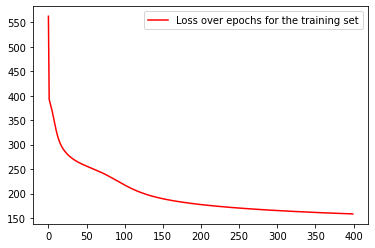

0.754


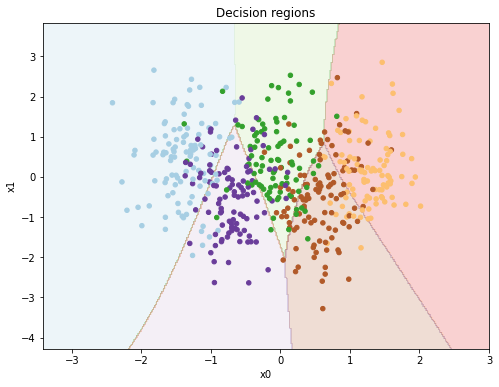

In [807]:
# I decided to implement early stopping here together with my classifier, even 
# tough i obiosuly could just use inheritance, and write it below. The 
# testing of early stopping is done in the next cell

class MNNClassifier():
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self, input_data, target_data, dim_hidden=5, eta = 0.01):
        """
        Being inspired by Marsland nad O'Reilly library, I decided to 
        create a constructor holding the most important variables, to 
        make writing the code easier. 
        """
        self.dim_in = input_data.shape[1]
        self.dim_out = target_data.shape[1]
        self.hidden_nodes = dim_hidden
        self.target = target_data
        self.n_examples = input_data.shape[0]
        self.eta=eta

        # Initializing the weights could've been done straight away without a method,
        # but since we've written a method for it already, it'll be faster
        self.hidden_weights = init_weights(self.dim_in, self.hidden_nodes)
        # Pay attention to the fact that we add 1 to the first dimension,
        # and the reason for that is that we usually add bias to the output 
        # of the hidden nodes.
        self.output_weights = init_weights(self.hidden_nodes, self.dim_out)
        
    def activation(self, z):
        return 1. / (1. + np.exp(-z))
    
    def back_propagation(self, Y):
        delta_output = (self.output-Y)*self.output*(1-self.output)
        delta_hidden = self.hidden_act*(1-self.hidden_act)*(delta_output@self.output_weights.T)
        return delta_output, delta_hidden
    
    def update_weights(self, X, g1, g2, eta): 
        self.hidden_weights -= (np.dot(add_bias(X).T,g1)) * eta 
        self.output_weights -= (np.dot(self.hidden_act.T,g2))  * eta 
        
    def loss(self,pred, Y): 
        """
        Calculating the loss by computing the difference betwenn predicted
        values and the target values, and the taking the square of it. 
        """
        return (0.5)*np.sum((Y-pred)**2)
    
    def forward(self, X): 
        
        # Again inspired by Marsland and O'Reilly, i save the hidden outputs 
        # so that I don't need to calculate it for each time
        net_hidden_input = add_bias(X)@self.hidden_weights 
        
        hidden_activation = self.activation(net_hidden_input)
        self.hidden_act = add_bias(hidden_activation)
        
        out_input = self.hidden_act@self.output_weights 
        self.output = self.activation(out_input)
        
        return self.output
        
    def fit(self, X_train, t_train, epochs=300): 
        
        loss_over_epochs = []
        for e in range(epochs): 
            output = self.forward(X_train)
            loss_over_epochs.append(self.loss(output, t_train))
        
            #calculating the delta terms using the back_propagation method
            delta_output, delta_hidden = self.back_propagation(t_train)
            
            self.update_weights(X_train, delta_hidden[:,1:], delta_output, self.eta)
            
        return loss_over_epochs, epochs
        
    def fit_early(self, X_train, t_train): 
        
        output = self.forward(X_train)
        loss = self.loss(output, t_train)
        #calculating the delta terms using the back_propagation method
        delta_output, delta_hidden = self.back_propagation(t_train)
        self.update_weights(X_train, delta_hidden[:,1:], delta_output, self.eta)
        return loss  
        
    def predict(self, x): 
        output = self.forward(x)
        l = np.argmax(output, axis=1)
        
        return l.reshape(-1)
    
    def early_stopping(self, X_train, y_train, X_val, y_val, loss_diff, epochs): 
        
        #old_error2 = 10000
        old_error1 = 9999
        new_error = 9998
        epoch_count = 0
        loss_training = []
        loss_validation = []
        for epoch in range(epochs): 
            loss_training.append(self.fit_early(X_train, y_train))
            old_error1 = new_error 
            val = self.forward(X_val)
            new_error = self.loss(val, y_val)
            loss_validation.append(new_error**2)
            
            if (old_error1-new_error) <= loss_diff: 
                print("Learning stopped after: ", epoch, " epochs.")
                print("The increase in loss has fallen below the thresshold.")
                return epoch+1, loss_validation, loss_training
                break
        return epochs, loss_validation, loss_training
            

    
    def accuracy(self, X_test, t_test, **kwargs):
        """Calculate the accuracy of the classifier for the pair (X_test, t_test)
        Return the accuracy"""
        pred = self.predict(X_test, **kwargs)
        if len(pred.shape) > 1:
            pred = pred[:,0]
        return np.sum(pred==t_test)/len(pred)
    
def init_weights(first_dim, second_dim): 
    rgen = np.random.RandomState(np.random.randint(5000))
    weights = rgen.normal(loc=0.0, scale=0.4, size=(first_dim+1, second_dim))
    return np.array(weights)

def add_bias(X):    
    bias = -np.ones((X.shape[0],1))
    return np.concatenate([bias, X], axis=1)

def standardScaler(data_set): 
    
    scaled_data_set = (data_set - np.average(X_train, axis=0))/(np.std(X_train, axis=0))
    
    return scaled_data_set

def one_hot_encode(Y): 
    return (np.arange(np.max(Y) +1) == Y[:, None]).astype(int)

X_trained = standardScaler(X_train)
t_train1 = one_hot_encode(t_train)
X_v = standardScaler(X_val)
t_v = one_hot_encode(t_val)
x_test = standardScaler(X_test)

mlp = MNNClassifier(X_trained, t_train1, 5, eta = 0.009)
loss, epoch =  mlp.fit(X_trained, t_train1, epochs = 400)
plt.plot([i for i in range(epoch)], loss, 'r', label='Loss over epochs for the training set')
plt.legend()
plt.show()

print(mlp.accuracy(X_v, t_val))
plot_decision_regions(X_v, t_val, mlp)



## For in4050-students: Early stopping
The following part is only mandatory for in4050-students. In3050-students are also welcome to make it a try. Everybody has to return for the part 2 on multi-layer neural networks. 

There is a danger of overfitting if we run too many epochs of training. One way to control that is to use early stopping. We can use (X_val, t_val) as valuation set when training on (X_train, t_train).

Let *e=50* or *e=10* (You may try both or choose some other number) After *e* number of epochs, calculate the loss for both the training set (X_train, t_train) and the validation set (X_val, t_val), and store them.

Train a classifier for many epochs. Plot the losses for both the training set and the validation set in the same figure and see whether you get the same effect as in figure 4.11 in Marsland.

Modify the code so that the training stops if the loss on the validation set is not reduced by more than *t* after *e* many epochs, where *t* is a threshold you provide as a parameter. 

Run the classifier with various values for *t* and report the accuracy and the numberof epochs ran.

Learning stopped after:  319  epochs.
The increase in loss has fallen below the thresshold.


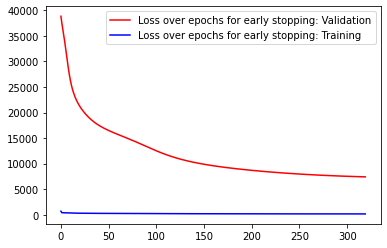

0.754


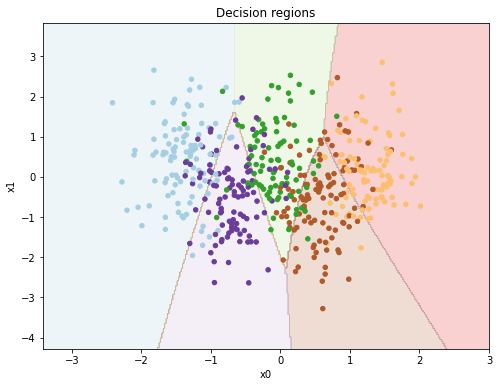

In [808]:

x_test = standardScaler(X_test)

mlp2 = MNNClassifier(X_trained, t_train1, 5, eta=0.01)

e, loss_v, loss_t = mlp2.early_stopping(X_trained, t_train1, X_v, t_v, loss_diff=0.03, epochs=2000)
plt.plot([i for i in range(e)], loss_v, 'r', label='Loss over epochs for early stopping: Validation')
plt.plot([i for i in range(e)], loss_t, 'b', label='Loss over epochs for early stopping: Training')
plt.legend()
plt.legend()
plt.show()

print(mlp2.accuracy(X_v, t_val))
plot_decision_regions(X_t, t_val, mlp2)

#print(mlp2.accuracy(x_test, t_t6/*696/690est))
#plot_decision_regions(x_test, t_test)

### Multi-class
Train the network on (X_train, t_train) (after scaling), and test on (X_val, t_val). Tune the hyperparameters to get the best result:
- number of epochs
- learning rate
- number of hidden nodes.

When you are content with the hyperparameters, you should run the same experiment 10 times, collect the accuracies and report the mean value and standard deviation of the accuracies across the experiments. This is common practise when you apply neural networks as the result may vary slightly between the runs. You may plot the decision boundaries for one of the runs.

Discuss shortly how the results and decsion boundaries compare to the "one-vs-rest" classifier.

### Binary class
Let us see whether a multilayer neural network can learn a non-linear classifier.
Train a classifier on (X_train, t2_train) and test it on (X_val, t2_val).
Tune the hyper-parameters for the best result. Run ten times with the best setting and report mean and standard deviation. Plot the decision boundaries.

The mean of the accuracies achieved for ten trainings of mlp with the best settings found is:  78.0  %
The standard deviation of the accuracies achieved for ten trainings of mlp with the best settings found is:  2.01  %


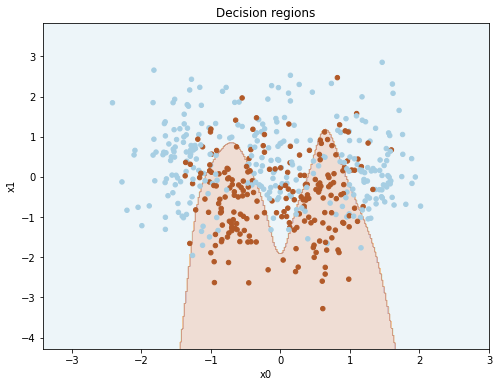

In [816]:
X_trained = standardScaler(X_train)
t_train1 = one_hot_encode(t2_train)
X_v = standardScaler(X_val)
t_v = one_hot_encode(t2_val)

accuracies = []
for i in range(10): 
    mlp = MNNClassifier(X_trained, t_train1, 5, eta=0.01)
    mlp.fit(X_trained, t_train1, epochs=2000)

    accuracies.append(mlp.accuracy(X_v, t2_val))

print('The mean of the accuracies achieved for ten trainings of mlp with the best settings found is: ', np.around(np.mean(accuracies),2)*100, ' %')
print('The standard deviation of the accuracies achieved for ten trainings of mlp with the best settings found is: ', np.around(np.std(accuracies),4)*100, ' %')
plot_decision_regions(X_t, t2_val, mlp)

# Part III: Final testing
We can now perform a final testing on the held-out test set.

## Binary task (X, t2)
Consider the linear regression classifier, the logistic regression classifier and the multi-layer network with the best settings you found. Train each of them on the training set and evaluate on the held-out test set, but also on the validation set and the training set. Report in a 3 by 3 table.

Comment on what you see. How do the three different algorithms compare? Also, compare the result between the different data sets. In cases like these, one might expect slightly inferior results on the held-out test data compared to the validation data. Is so the case? 

Also report precision and recall for class 1.


In [822]:
# Linear regression
lrgd1 = LinearRegressionClassifier()
lrgd1.fit(X_train, t2_train, 0.00001, eta=0.05, epochs = 1000,val=[])

# Logisitc regression 
lrgd2 = LogisiticRegressionClassifier()
lrgd2.fit(X_train, t2_train, loss_diff=0.00001, epochs = 30, eta=0.2, val=[])

X_trained = standardScaler(X_train)
t_train1 = one_hot_encode(t2_train)
X_v = standardScaler(X_val)
t_v = one_hot_encode(t2_val)
X_test2 = standardScaler(X_test)
#t2_test = one_hot_encode(t2_test)

# MLP with early stopping implemented
mlp2 = MNNClassifier(X_trained, t_train1, 5, eta=0.01)
mlp2.fit(X_trained, t_train1, epochs=2000)

table = np.zeros((5,5))

print('\n')
print(23*" "+ "Accuracies using different classifiers")
print("|{:20}|{:20}|{:20}|{:15}|".format("Dataset/Clasifier","Linear Regression", "Logistic Regression", " MLP"))
print(80*"-")
print("|{:20}|{:20}|{:20}|{:15}|".format("Training set", np.around(lrgd1.accuracy(X_train, t2_train)*100,1), np.around(lrgd2.accuracy(X_train, t2_train)*100,1), np.around(mlp2.accuracy(X_trained, t2_train)*100,1)))
print(80*"-")
print("|{:20}|{:20}|{:20}|{:15}|".format("Validation set", np.around(lrgd1.accuracy(X_val, t2_val)*100,1), np.around(lrgd2.accuracy(X_val, t2_val)*100,1), np.around(mlp2.accuracy(X_v, t2_val)*100,1)))
print(80*"-")
print("|{:20}|{:20}|{:20}|{:15}|".format("Test set", np.around(lrgd1.accuracy(X_test, t2_test)*100,1), np.around(lrgd2.accuracy(X_test, t2_test)*100,1), np.around(mlp2.accuracy(X_test2, t2_test)*100,1)))
print(80*"-")

# This method only returns recall and precision for the positive class 1
def recall_precision(predicted, gold):
    
    table = np.zeros((2,2))
    for p,g in zip(predicted, gold):
        table[int(p), g] +=1
    recall_0 = table[0,0]/np.sum(table[:2, 0])
    precision_0 = table[1,1]/np.sum(table[1, :2])
    recall_1 = table[0,0]/np.sum(table[:2, 0])
    precision_1 = table[1,1]/np.sum(table[1, :2])
    avr_recall = recall_1
    avr_precision = precision_1
    return avr_recall, avr_precision 

lrgd1_train = recall_precision(lrgd1.predict(X_train), t2_train)
lrgd1_val = recall_precision(lrgd1.predict(X_val), t2_val)
lrgd1_test = recall_precision(lrgd1.predict(X_test), t2_test)
lrgd2_train = recall_precision(lrgd2.predict(X_train), t2_train)
lrgd2_val = recall_precision(lrgd1.predict(X_val), t2_val)
lrgd2_test = recall_precision(lrgd1.predict(X_test), t2_test)
mlp2_train = recall_precision(mlp2.predict(X_trained), t2_train)
mlp2_val = recall_precision(mlp2.predict(X_v), t2_val)
mlp2_test = recall_precision(mlp2.predict(X_test2), t2_test)

print('\n')
print(23*" "+ "Recall and precision for different classifiers: ")
print("|{:20}|{:29}|{:29}|{:29}|".format("Dataset/Clasifier","Linear Regression", "Logistic Regression", " MLP"))
print(112*"-")
print("|{:20}|{:29}|{:29}|{:29}|".format("Training set", f'Recall: {np.around(lrgd1_train[0],2)} Precision: {np.around(lrgd1_train[1],2)}', 
                                          f'Recall: {np.around(lrgd2_train[0],2)} Precision: {np.around(lrgd2_train[1],2)}', 
                                          f'Recall: {np.around(mlp2_train[0],2)} Precision: {np.around(mlp2_train[1],2)}'))
print(112*"-")
print("|{:20}|{:29}|{:29}|{:29}|".format("Validation set", f'Recall: {np.around(lrgd1_val[0],2)} Precision: {np.around(lrgd1_val[1],2)}', 
                                         f'Recall: {np.around(lrgd2_val[0],2)} Precision: {np.around(lrgd2_val[1],2)}', 
                                         f'Recall: {np.around(mlp2_val[0],2)} Precision: {np.around(mlp2_val[1],2)}'))
print(112*"-")
print("|{:20}|{:29}|{:29}|{:29}|".format("Test set", f'Recall: {np.around(lrgd1_test[0],2)} Precision: {np.around(lrgd1_test[1],2)}', 
                                         f'Recall: {np.around(lrgd2_test[0],2)} Precision: {np.around(lrgd2_test[1],2)}', 
                                         f'Recall: {np.around(mlp2_test[0],2)} Precision: {np.around(mlp2_test[1],2)}'))
print(112*"-")




9.885233658054965e-06
409


                       Accuracies using different classifiers
|Dataset/Clasifier   |Linear Regression   |Logistic Regression | MLP           |
--------------------------------------------------------------------------------
|Training set        |                70.7|                71.8|           80.0|
--------------------------------------------------------------------------------
|Validation set      |                66.8|                66.8|           78.2|
--------------------------------------------------------------------------------
|Test set            |                72.6|                71.8|           80.6|
--------------------------------------------------------------------------------


                       Recall and precision for different classifiers: 
|Dataset/Clasifier   |Linear Regression            |Logistic Regression          | MLP                         |
---------------------------------------------------------------------------

### Comment on what you see - from student

From the datasets it's pretty clear that as we move towards right, the accuracy achieved by the differenct classifiers increases. It's of no suprise that the classifiers achieve a bit lower accuracy on the validations set, however the accuracy achieved on the test sets was a pleasant suprise. Obviously the results achieved on the held-out tests aren't inferior to the ones achieved on the previous sets, as they either achieve similiar or even superior results to the accuracies achieved on the training sets. 

## Multi-class task (X, t)
For IN3050 students compare the one-vs-rest classifier to the multi-layer preceptron. Evaluate on test, validation and training set as above. In4050-students should also include results from the multi-nomial logistic regression.

Comment on the results.

In [811]:
indices = np.arange(X.shape[0])
rng = np.random.RandomState(2022)
rng.shuffle(indices)
indices[:10]

X_train = X[indices[:1000],:]
X_val = X[indices[1000:1500],:]
X_test = X[indices[1500:],:]
t_train = t[indices[:1000]]
t_val = t[indices[1000:1500]]
t_test = t[indices[1500:]]

t2_train = t_train >= 3
t2_train = t2_train.astype('int')
t2_val = (t_val >= 3).astype('int')
t2_test = (t_test >= 3).astype('int')


In [812]:
# This method returns the average precision and recall for all 5 classes using each classifier

def recall_precision2(predicted, gold, if_print='no'):
    table = np.zeros((5,5))
    for p,g in zip(predicted, gold):
        table[int(p), g] +=1
    if if_print == 'yes': 
        print(28*" "+ "Confusion matrix for: " + classifier_used )
        print("{:20}|{:>9}|{:>9}|{:>9}|{:>9}|{:>9}|".format(" ","0" ,"1" , "2", "3", "4"))
        print(10*" "+61*"-")
        print("{:10}{:10}|{:9}|{:9}|{:9}|{:9}|{:9}|".format(" ","0", table[0,0], table[0,1],table[0,2],table[0,3],table[0,4]))
        print(10*" "+61*"-")
        print("{:10}{:10}|{:9}|{:9}|{:9}|{:9}|{:9}|".format(" ","1", table[1,0], table[1,1],table[1,2],table[1,3],table[1,4]))
        print(10*" "+61*"-")
        print("{:10}{:10}|{:9}|{:9}|{:9}|{:9}|{:9}|".format(" ","2", table[2,0], table[2,1],table[2,2],table[2,3],table[2,4]))
        print(10*" "+61*"-")
        print("{:10}{:10}|{:9}|{:9}|{:9}|{:9}|{:9}|".format(" ","3", table[3,0], table[3,1],table[3,2],table[3,3],table[3,4]))
        print(10*" "+61*"-")
        print("{:10}{:10}|{:9}|{:9}|{:9}|{:9}|{:9}|".format(" ","4", table[4,0], table[4,1],table[4,2],table[4,3],table[4,4]))
        print(10*" "+61*"-")
    recall_0 = table[0,0]/np.sum(table[:5, 0])
    precision_0 = table[0,0]/np.sum(table[0, :5])
    recall_1 = table[1,1]/np.sum(table[:5, 1])
    precision_1 = table[1,1]/np.sum(table[1, :5])
    recall_2 = table[2,2]/np.sum(table[:5, 2])
    precision_2 = table[2,2]/np.sum(table[2, :5])
    recall_3 = table[3,3]/np.sum(table[:5, 3])
    precision_3 = table[3,3]/np.sum(table[3, :5])
    recall_4 = table[4,4]/np.sum(table[:5, 4])
    precision_4 = table[4,4]/np.sum(table[4, :5])
    avr_precision = (precision_0+precision_1+precision_2+precision_3+precision_4)/5
    avr_recall = (recall_0+recall_1+recall_2+recall_3+recall_4)/5
    return avr_precision, avr_recall
    

In [828]:
# One-vs.-rest
mLRGD = MultiLRGD()
mLRGD.fit(X_train, t_train, loss_diff = 0.0001, epochs = 10000, eta=0.2)

# Multinomial logisitc regression 
sLRGD = SoftLRGD()
y_train = one_hot_encode(t_train)
y_val = one_hot_encode(t_val)
sLRGD.fit(X_train, y_train, loss_diff = 0.0001, epochs = 3000, eta=0.1)

X_trained = standardScaler(X_train)
t_train1 = one_hot_encode(t_train)
X_v = standardScaler(X_val)
t_v = one_hot_encode(t_val)
X_test2 = standardScaler(X_test)
t_test2 = one_hot_encode(t_test)

# MLP with early stopping implemented
mlp2 = MNNClassifier(X_trained, t_train1, 5, eta=0.01)
mlp2.fit(X_trained, t_train1, epochs=2000)


print('\n')
print(23*" "+ "Accuracies using different classifiers")
print("|{:17}|{:23}|{:19}|{:12}|".format("Dataset/Clasifier","OvR Logistic Regression", "Multinomial Regression", "MLP"))
print(79*"-")
print("|{:17}|{:23}|{:19}|{:15}|".format("Training set", np.around(mLRGD.accuracy(X_train, t_train)*100,1), np.around(sLRGD.accuracy(X_train, t_train)*100,1), np.around(mlp2.accuracy(X_trained, t_train)*100,1)))
print(79*"-")
print("|{:17}|{:23}|{:19}|{:15}|".format("Validation set", np.around(mLRGD.accuracy(X_val, t_val)*100,1), np.around(sLRGD.accuracy(X_val, t_val)*100,1), np.around(mlp2.accuracy(X_v, t_val)*100,1)))
print(79*"-")
print("|{:17}|{:23}|{:19}|{:15}|".format("Test set", np.around(mLRGD.accuracy(X_test, t_test)*100,1), np.around(sLRGD.accuracy(X_test, t_test)*100,1), np.around(mlp2.accuracy(X_test2, t_test)*100,1)))
print(79*"-")

mLRGD_train = recall_precision2(mLRGD.predict(X_train), t_train)
mLRGD_val = recall_precision2(mLRGD.predict(X_val), t_val)
mLRGD_test = recall_precision2(mLRGD.predict(X_test), t_test)
sLRGD_train = recall_precision2(sLRGD.predict(X_train), t_train)
sLRGD_val = recall_precision2(sLRGD.predict(X_val), t_val)
sLRGD_test = recall_precision2(sLRGD.predict(X_test), t_test)
mlp2_train = recall_precision2(mlp2.predict(X_trained), t_train)
mlp2_val = recall_precision2(mlp2.predict(X_v), t_val)
mlp2_test = recall_precision2(mlp2.predict(X_test2), t_test)

print('\n')
print(23*" "+ "Recall and precision for different classifiers: ")
print("|{:20}|{:29}|{:29}|{:29}|".format("Dataset/Clasifier","Linear Regression", "Logistic Regression", " Multi-Layer Perceptron"))
print(112*"-")
print("|{:20}|{:29}|{:29}|{:29}|".format("Training set", f'Recall: {np.around(mLRGD_train[0],2)} Precision: {np.around(mLRGD_train[1],2)}', 
                                          f'Recall: {np.around(sLRGD_train[0],2)} Precision: {np.around(sLRGD_train[1],2)}', 
                                          f'Recall: {np.around(mlp2_train[0],2)} Precision: {np.around(mlp2_train[1],2)}'))
print(112*"-")
print("|{:20}|{:29}|{:29}|{:29}|".format("Validation set", f'Recall: {np.around(mLRGD_val[0],2)} Precision: {np.around(mLRGD_val[1],2)}', 
                                         f'Recall: {np.around(sLRGD_val[0],2)} Precision: {np.around(sLRGD_val[1],2)}', 
                                         f'Recall: {np.around(mlp2_val[0],2)} Precision: {np.around(mlp2_val[1],2)}'))
print(112*"-")
print("|{:20}|{:29}|{:29}|{:29}|".format("Test set", f'Recall: {np.around(mLRGD_test[0],2)} Precision: {np.around(mLRGD_test[1],2)}', 
                                         f'Recall: {np.around(sLRGD_test[0],2)} Precision: {np.around(sLRGD_test[1],2)}', 
                                         f'Recall: {np.around(mlp2_test[0],2)} Precision: {np.around(mlp2_test[1],2)}'))
print(112*"-")

Training stopped after  814  epochs
The minimal threshold value for error is reached:  9.999350994488745e-05
Training stopped after  447  epochs
The minimal threshold value for error is reached:  9.946774105539957e-05
Training stopped after  109  epochs
The minimal threshold value for error is reached:  9.283371415662301e-05
Training stopped after  1167  epochs
The minimal threshold value for error is reached:  9.970617291914283e-05


                       Accuracies using different classifiers
|Dataset/Clasifier|OvR Logistic Regression|Multinomial Regression|MLP         |
-------------------------------------------------------------------------------
|Training set     |                   75.0|               78.5|           79.6|
-------------------------------------------------------------------------------
|Validation set   |                   75.4|               76.0|           77.6|
-------------------------------------------------------------------------------
|Test set         |

### Comment from student 

The case is similiar as when we were classifying binary classes, the further to the right, the better the results. It is however worth mentioning that multinomial classifier does pretty much as good as the mlp. Again the classifiers behave the asme way as the classifiers used for binary classification, a little worse on validation set, and at least as good on test set as on training sets, if not better than at training sets. There's really not much more to say, the tables tell us everything else we need to know 